<a href="https://colab.research.google.com/github/gaetanbrison/AnomalyDAE/blob/master/swap_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Swap Approach

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torchsummary import summary
import numpy as np
torch.manual_seed(0)

## I - Swap Functions



In [ ]:
def swap_tensor(input,indexes):
  """ swap the elements of a layer(neurons) 

  Parameters:
    input: torch.Tensor - float 32
    The input tensor
    
    indexes: list
    The indexes of the neurons that are in equilibrium

  Returns:
    Returns a Tensor that is the combination on one side of the neurons at
    equilibrium and the other side the neurons to update based on indexes

  Warnings:
    1) idx(i) <> idx(i+n)
    2) idx(i+1) > idx(i)
  """

  arr = input.detach().numpy()
  arr_eq = arr[indexes]
  arr_update = np.delete(arr, indexes)
  arr_swap = np.concatenate((arr_eq,arr_update))


  return torch.tensor(arr_swap)

In [ ]:
def swap_weight(weights,indexes):

  """ swap the elements of a weight matrix 
  Parameters:
    weights: torch.Tensor - float 32
    The weights matrix 

    indexes: torch.Tensor - float 32
    The indexes of the neurons' weights that are in equilibrium

  Returns:
    The weights matrix after the swap operations
  """

  arr_w = np.array(weights.T.tolist(), dtype="float32")
  arr_w_eq = arr_w[indexes]
  arr_w_update = np.delete(arr_w, indexes,0)
  arr_w_swap = np.concatenate((arr_w_eq,arr_w_update))

  return torch.tensor(arr_w_swap).T


validation of the two functions : swap_tensor & swap_weight

In [ ]:
# input & weights
inputs=torch.randn(123)
weights=torch.randn(5,123)

In [ ]:
# swaped input & weights
inputs_swaped=swap_tensor(inputs,[1,4,45,3,44,2])
weights_swaped=swap_weight(weights,[1,4,45,3,44,2])

In [ ]:
display(inputs_swaped.shape)
display(weights_swaped.shape)
display(inputs_swaped.dtype)
display(weights_swaped.dtype)
display(inputs_swaped.sum())
display(weights_swaped.sum())

torch.Size([123])

torch.Size([5, 123])

torch.float32

torch.float32

tensor(-0.6675)

tensor(25.0241)

In [ ]:
type(inputs_swaped[0])

torch.Tensor

In [ ]:
inputs_swaped[0]

tensor(-1.1524)

In [ ]:
# result with input & weights
torch.matmul(inputs,weights.T)

tensor([  2.2635, -22.3689,  -4.2215,  22.5222,  -0.2775])

In [ ]:
# result with swaped input & weights

torch.matmul(inputs_swaped,weights_swaped.T)

# we obtain the same result as the previous ==> OK

tensor([  2.2635, -22.3689,  -4.2215,  22.5222,  -0.2775])

## II - Example

In [ ]:
inputs = torch.Tensor([1,4,1,7,3])
weights=torch.Tensor([[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15]])

In [ ]:
display(inputs.shape)
display(weights.shape)

torch.Size([5])

torch.Size([3, 5])

In [ ]:
inputs_swaped=swap_tensor(inputs,[1,3])
weights_swaped=swap_weight(weights,[1,3])

In [ ]:
# result with input & weights
torch.matmul(inputs,weights.T)

tensor([ 55., 135., 215.])

In [ ]:
torch.matmul(inputs_swaped,weights_swaped.T)

tensor([ 55., 135., 215.])

In [ ]:
eq_indexes_list=[[],[1,3],[1,2],[1],[]]
for list_indexes in eq_indexes_list:
  print(list_indexes)
  print(swap_tensor(inputs,list_indexes))

[]
tensor([1., 4., 1., 7., 3.])
[1, 3]
tensor([4., 7., 1., 1., 3.])
[1, 2]
tensor([4., 1., 1., 7., 3.])
[1]
tensor([4., 1., 1., 7., 3.])
[]
tensor([1., 4., 1., 7., 3.])


In [ ]:
eq_indexes_list=[[],[1,3],[1,2],[1],[]]
for list_indexes in eq_indexes_list:
  print(list_indexes)
  print(swap_weight(weights,list_indexes))

[]
tensor([[ 1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10.],
        [11., 12., 13., 14., 15.]])
[1, 3]
tensor([[ 2.,  4.,  1.,  3.,  5.],
        [ 7.,  9.,  6.,  8., 10.],
        [12., 14., 11., 13., 15.]])
[1, 2]
tensor([[ 2.,  3.,  1.,  4.,  5.],
        [ 7.,  8.,  6.,  9., 10.],
        [12., 13., 11., 14., 15.]])
[1]
tensor([[ 2.,  1.,  3.,  4.,  5.],
        [ 7.,  6.,  8.,  9., 10.],
        [12., 11., 13., 14., 15.]])
[]
tensor([[ 1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10.],
        [11., 12., 13., 14., 15.]])



## III - Neurons Swap

Let's start with a simple neural network, and assume that the green neurons(7,9,12,13,16) are in equilibrium

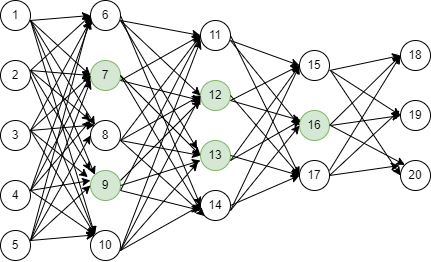

In [ ]:

"""the indices of the neurons that are in equilibrium are :

nothing for layer 1
[1,3] for layer 2
[1,2] for layer 3
[1] for layer 4
nothing for layer 5 """


eq_indexes_list=[[],[1,3],[1,2],[1],[]]

In [ ]:
# A simple hook class that returns the input and output of a layer during forward/backward pass
# It'll be used to verify if the swap went well throughout the layers(inputs&outputs)

class Hook():

    def __init__(self, module, backward=False):
      
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output

    def close(self):
        self.hook.remove()

In [ ]:
class NN(nn.Module):

    def __init__(self,input_size,output_size):

        super(NN, self).__init__()
        self.linear1=nn.Linear(input_size, 5,bias=False)
        self.linear2=nn.Linear(5, 4,bias=False)
        self.linear3=nn.Linear(4, 3,bias=False)
        self.linear4=nn.Linear(3, output_size,bias=False)


    def forward(self, x):

        x = self.linear1(x)
        x = nn.functional.relu(x)

        x = self.linear2(x)
        x = nn.functional.relu(x)

        x = self.linear3(x)
        x = nn.functional.relu(x)

        x = self.linear4(x)

        return x

We make a copy of the neural network, and add the necessary modifications to allow permutations of neurons. 




In [ ]:
class NN_Modifed(nn.Module):

    def __init__(self,input_size,output_size):

        super(NN_Modifed, self).__init__()
        self.linear1=nn.Linear(input_size, 5,bias=False)
        self.linear2=nn.Linear(5, 4,bias=False)
        self.linear3=nn.Linear(4, 3,bias=False)
        self.linear4=nn.Linear(3, output_size,bias=False)


    def forward(self, x,eq_indexes_list):
        x=swap_tensor(x,eq_indexes_list[0])
        
        x = self.linear1(x)
        x = nn.functional.relu(x)
        x=swap_tensor(x,eq_indexes_list[1])


        x = self.linear2(x)
        x = nn.functional.relu(x)
        x=swap_tensor(x,eq_indexes_list[2])

        x = self.linear3(x)
        x = nn.functional.relu(x)
        x=swap_tensor(x,eq_indexes_list[3])

        x = self.linear4(x)

        return x

In [ ]:
# make a copy of the NN parameters to NN_Modifed
import random

model1=NN(5,3)
model2=NN_Modifed(5,3)

model2.load_state_dict(model1.state_dict())


<All keys matched successfully>

In [ ]:
model1.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 1.4668e-01, -3.9180e-01,  2.4516e-01,  2.3280e-01,  2.7736e-01],
                      [-2.8512e-01,  4.4543e-01, -2.6509e-01,  4.4647e-01, -4.2919e-01],
                      [-3.9845e-01,  2.7468e-01,  4.6740e-02,  2.5799e-02, -2.4765e-01],
                      [-1.8760e-01, -1.3076e-01, -4.3566e-01,  2.3241e-02,  7.9094e-02],
                      [-3.7862e-04,  1.4442e-01,  4.2434e-01,  1.1891e-01, -1.6371e-01]])),
             ('linear2.weight',
              tensor([[-0.1840, -0.2861, -0.3100, -0.0720, -0.0791],
                      [ 0.1989, -0.1912,  0.3565, -0.3138,  0.0013],
                      [ 0.4020,  0.4447, -0.2591,  0.0797,  0.0528],
                      [-0.2097, -0.1545,  0.1211, -0.3110,  0.0738]])),
             ('linear3.weight', tensor([[ 0.2164, -0.1970,  0.4153, -0.0329],
                      [ 0.2269,  0.4952, -0.1528,  0.2717],
                      [-0.1430, -0.0730, -0.0847, -0.0031]])),
        

swapping the neurons requires swapping the weights as well to get the same result at the end

In [ ]:
# swap the parameters using swap_weight

with torch.no_grad():
  for idx,layer in enumerate(list(model2.children())):
    for param in layer.parameters():
      param.copy_(swap_weight(param,eq_indexes_list[idx]))


In [ ]:
# input data
data=torch.randn(5,requires_grad=False)

In [ ]:
model2.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 1.4668e-01, -3.9180e-01,  2.4516e-01,  2.3280e-01,  2.7736e-01],
                      [-2.8512e-01,  4.4543e-01, -2.6509e-01,  4.4647e-01, -4.2919e-01],
                      [-3.9845e-01,  2.7468e-01,  4.6740e-02,  2.5799e-02, -2.4765e-01],
                      [-1.8760e-01, -1.3076e-01, -4.3566e-01,  2.3241e-02,  7.9094e-02],
                      [-3.7862e-04,  1.4442e-01,  4.2434e-01,  1.1891e-01, -1.6371e-01]])),
             ('linear2.weight',
              tensor([[-0.2861, -0.0720, -0.1840, -0.3100, -0.0791],
                      [-0.1912, -0.3138,  0.1989,  0.3565,  0.0013],
                      [ 0.4447,  0.0797,  0.4020, -0.2591,  0.0528],
                      [-0.1545, -0.3110, -0.2097,  0.1211,  0.0738]])),
             ('linear3.weight', tensor([[-0.1970,  0.4153,  0.2164, -0.0329],
                      [ 0.4952, -0.1528,  0.2269,  0.2717],
                      [-0.0730, -0.0847, -0.1430, -0.0031]])),
        

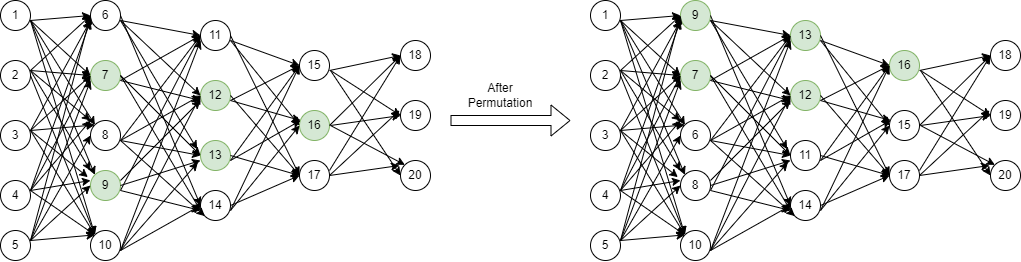

## IV - Comparaison

In [ ]:
# register hooks on each layer
hookF1 = [Hook(layer[1]) for layer in list(model1._modules.items())]
hookF2 = [Hook(layer[1]) for layer in list(model2._modules.items())]

# run a data batch
out1=model1(data)
out2 = model2(data,eq_indexes_list)

print('***'*3+'  Forward Hooks Inputs & Outputs for model1  '+'***'*3)
for idx,hook1 in enumerate(hookF1):
    print("\t Layer ",idx+1)

    print("Inuput : ",hook1.input)
    print("Output : ",hook1.output)
    print('---'*17)
    
print('\n')
print('\n')

print('***'*3+'  Forward Hooks Inputs & Outputs for model2(With Neurons swap)  '+'***'*3)
for idx,hook2 in enumerate(hookF2):
    print("\t Layer ",idx+1)
    print("Inuput : ",hook2.input)
    print("Output : ",hook2.output)
    print('---'*17)



*********  Forward Hooks Inputs & Outputs for model1  *********
	 Layer  1
Inuput :  (tensor([-1.1744, -1.4021,  1.0038, -0.7704,  1.3836]),)
Output :  tensor([ 0.8276, -1.4936, -0.2328,  0.0579, -0.0942],
       grad_fn=<SqueezeBackward3>)
---------------------------------------------------
	 Layer  2
Inuput :  (tensor([0.8276, 0.0000, 0.0000, 0.0579, 0.0000], grad_fn=<ReluBackward0>),)
Output :  tensor([-0.1565,  0.1465,  0.3373, -0.1915], grad_fn=<SqueezeBackward3>)
---------------------------------------------------
	 Layer  3
Inuput :  (tensor([0.0000, 0.1465, 0.3373, 0.0000], grad_fn=<ReluBackward0>),)
Output :  tensor([ 0.1112,  0.0210, -0.0393], grad_fn=<SqueezeBackward3>)
---------------------------------------------------
	 Layer  4
Inuput :  (tensor([0.1112, 0.0210, 0.0000], grad_fn=<ReluBackward0>),)
Output :  tensor([-0.0214,  0.0383, -0.0340], grad_fn=<SqueezeBackward3>)
---------------------------------------------------




*********  Forward Hooks Inputs & Outputs for 

In [ ]:
# out = out2 ==> permutation : OK 
print(out1)
print(out2)

tensor([-0.0214,  0.0383, -0.0340], grad_fn=<SqueezeBackward3>)
tensor([-0.0214,  0.0383, -0.0340], grad_fn=<SqueezeBackward3>)


NEXT STEP :  generalize & automate the swap process..by using Classes,decorators for example...

## V - Backpropagation

### i - Intro

## Autograd - Automatic Differentiation


The PyTorch <a href='https://pytorch.org/docs/stable/autograd.html'><strong><tt>autograd</tt></strong></a> package provides automatic differentiation for all operations on Tensors. This is because operations become attributes of the tensors themselves. When a Tensor's <tt>.requires_grad</tt> attribute is set to True, it starts to track all operations on it. When an operation finishes you can call <tt>.backward()</tt> and have all the gradients computed automatically. The gradient for a tensor will be accumulated into its <tt>.grad</tt> attribute.
    


### ii - Simple Backpropagation

We'll start by applying a single polynomial function $y = f(x)$ to tensor $x$. Then we'll backprop and print the gradient $\frac {dy} {dx}$.

$\begin{split}Function:\quad y &= 2x^4 + x^3 + 3x^2 + 5x + 1 \\
Derivative:\quad y' &= 8x^3 + 3x^2 + 6x + 5\end{split}$



#### Step 1. Perform standard imports

In [ ]:
import torch

#### Step 2. Create a tensor with <tt>requires_grad</tt> set to True
This sets up computational tracking on the tensor.

In [ ]:
x = torch.tensor(2.0, requires_grad=True)

#### Step 3. Define a function

In [ ]:
y = 2*x**4 + x**3 + 3*x**2 + 5*x + 1

print(y)

tensor(63., grad_fn=<AddBackward0>)


Since $y$ was created as a result of an operation, it has an associated gradient function accessible as <tt>y.grad_fn</tt><br>
The calculation of $y$ is done as:<br>

$\quad y=2(2)^4+(2)^3+3(2)^2+5(2)+1 = 32+8+12+10+1 = 63$

This is the value of $y$ when $x=2$.


#### Step 4. Backprop

In [ ]:
y.backward()

#### Step 5. Display the resulting gradient

In [ ]:
print(x.grad)

tensor(93.)


Note that <tt>x.grad</tt> is an attribute of tensor $x$, so we don't use parentheses. The computation is the result of<br>

$\quad y'=8(2)^3+3(2)^2+6(2)+5 = 64+12+12+5 = 93$

This is the slope of the polynomial at the point $(2,63)$.

### iii - Backpropagation on multiple steps

Now let's do something more complex, involving layers $y$ and $z$ between $x$ and our output layer $out$.

#### 1. Create a tensor

In [ ]:
x = torch.tensor([[1.,2,3],[3,2,1]], requires_grad=True)
print(x)

tensor([[1., 2., 3.],
        [3., 2., 1.]], requires_grad=True)


#### 2. Create the first layer with $y = 3x+2$

In [ ]:
y = 3*x + 2
print(y)

tensor([[ 5.,  8., 11.],
        [11.,  8.,  5.]], grad_fn=<AddBackward0>)


#### 3. Create the second layer with $z = 2y^2$

In [ ]:
z = 2*y**2
print(z)

tensor([[ 50., 128., 242.],
        [242., 128.,  50.]], grad_fn=<MulBackward0>)


#### 4. Set the output to be the matrix mean

In [ ]:
out = z.mean()
print(out)

tensor(140., grad_fn=<MeanBackward0>)


#### 5. Now perform back-propagation to find the gradient of x w.r.t out

In [ ]:
out.backward()
print(x.grad)

tensor([[10., 16., 22.],
        [22., 16., 10.]])


You should see a 2x3 matrix. If we call the final <tt>out</tt> tensor "$o$", we can calculate the partial derivative of $o$ with respect to $x_i$ as follows:<br>

$o = \frac {1} {6}\sum_{i=1}^{6} z_i$<br>

$z_i = 2(y_i)^2 = 2(3x_i+2)^2$<br>

To solve the derivative of $z_i$ we use the <a href='https://en.wikipedia.org/wiki/Chain_rule'>chain rule</a>, where the derivative of $f(g(x)) = f'(g(x))g'(x)$<br>

In this case<br>

$\begin{split} f(g(x)) &= 2(g(x))^2, \quad &f'(g(x)) = 4g(x) \\
g(x) &= 3x+2, &g'(x) = 3 \\
\frac {dz} {dx} &= 4g(x)\times 3 &= 12(3x+2) \end{split}$

Therefore,<br>

$\frac{\partial o}{\partial x_i} = \frac{1}{6}\times 12(3x+2)$<br>

$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = 2(3(1)+2) = 10$

$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=2} = 2(3(2)+2) = 16$

$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=3} = 2(3(3)+2) = 22$

### iv - Backpropagation from Scratch

In [ ]:
# Load libraries
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [ ]:
# Loading our MNIST dataset
data = load_digits()
X = data['data']
y = data['target']


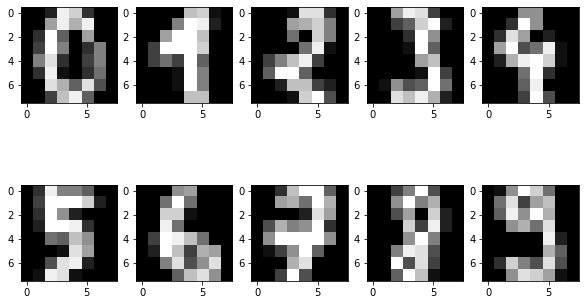

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,6))
for i in range(10):
    img = np.reshape(X[y == i][5],(8,8))
    ax[int(i/5)][i%5].imshow(img, cmap='gray')


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X/16, y, test_size=0.3)

In [ ]:
# The class Layer, uniquely defines the attributes and functionalities of a layer e.g. size, activation function, weights etc.
class Layer:
    # Initializes the basic attributes of a single layer
    def __init__(self, size, index, activation='sigmoid'):
        self.size = size # defines the number of stacked neurons in the layer
        self.activation_func = activation # defines the activation function that each neuron in the layer uses
        self.layer_index = index # defines the location of layer in the network
        self.a = 0 # defines the output of the layer after running through activation
        self.z = 0 # defines the input of layer to the activation function
        
    # Weight initialization is very important or the we might see vanishing/exploding gradient problem
    # We use Glroot Initialization technique to intialize our weights and biases
    def init_weight(self, input_shape, output_shape):
        mean = 0
        std = np.sqrt(2/(input_shape + output_shape))
        self.weights = np.float32(np.random.uniform(-std, std, (output_shape, input_shape)))
        self.bias = np.float32(np.random.uniform(-std, std, (output_shape,1)))
    
    # return the output of layer after running the input through selected activation function
    def activation(self, inputs):
        self.z = np.dot(self.weights,inputs) + self.bias
        self.a = 1/(1 + np.exp(-self.z))
        return self.a
    
    # provides the derivative of activation function for the current output of the layer
    def activation_grad(self):
        return self.a * (1 - self.a)       


In [ ]:
# Class Neural Network, defines multiple layers and runs forwad and back propogation to train the network.
class NeuralNetwork:
    
    # defines the shape of Network and initializes layers
    def __init__(self, shape):
        self.shape = shape
        self.layers = list()
        self.log_loss_hist = list()
        j = 0
        for i in shape:
            self.layers.append(Layer(i,j))
            j = j + 1
        
    # Initializes the weights and biases of our network for each layer
    def initialize(self, X, y):
        for i in range(len(self.layers)):
            if i == 0:
                self.layers[i].init_weight(X.shape[1], self.layers[i].size)
            else:
                self.layers[i].init_weight(self.layers[i-1].size, self.layers[i].size)
       
    # performs forward propogation
    def forward_propogation(self, X):
        a = X.T
        for layer in self.layers:
            a = layer.activation(a)
    # calculates log logs and return the result
    def loss(self, outputs, y):
        lb = LabelBinarizer()
        y_lb = lb.fit_transform(y)
        outputs_lb = lb.transform(outputs)
        loss = log_loss(y_lb, outputs_lb)
        return loss
    
    # Performs the most critical, Backpropogation to calculate delta values for each layer
    def backpropogate(self, X, y):
        delta = list()
        delta_w = [0 for _ in range(len(self.layers))]
        delta_b = [0 for _ in range(len(self.layers))]
        error_o = (self.layers[-1].z - y.T)
        for i in reversed(range(len(self.layers) - 1)):
            error_i = np.multiply(self.layers[i+1].weights.T.dot(error_o), self.layers[i].activation_grad())
            delta_w[i+1] = error_o.dot(self.layers[i].a.T)/len(y)
            delta_b[i+1] = np.sum(error_o, axis=1, keepdims=True)/len(y)
            error_o = error_i
        delta_w[0] = error_o.dot(X)
        delta_b[0] = np.sum(error_o, axis=1, keepdims=True)/len(y)
        return (delta_w, delta_b)
        
    # Uses the delta values to update weights and biases
    def update_weights_bias(self, delta_w, delta_b, lr):
        #print(self.layers[0].bias.shape)

        for i in range(len(self.layers)):
            layer = self.layers[i]
            layer.weights = layer.weights - (lr*delta_w[i])
            layer.bias = layer.bias - (lr*delta_b[i]) 
    
    # Used to orchestrate the training of network, given a certain epoch and learning rate
    def train(self, X, y, epochs, batch_size, lr):
        self.initialize(X, y)
        lb = LabelBinarizer()
        y_lb = lb.fit_transform(y)
        y_lb = lb.fit_transform(y)
        for i in range(epochs):
            low = 0
            high = low + batch_size
            self.log_loss_hist.append(self.loss(np.argmax(self.predict(X), axis=0), y))
            while(low < X.shape[0]):
                X_bat = X[low:high,:]
                y_bat = y_lb[low:high]
                self.forward_propogation(X_bat)
                outputs = self.layers[-1].a
                delta_w, delta_b = self.backpropogate(X_bat, y_bat)
                self.update_weights_bias(delta_w, delta_b, lr)
                low = high
                if (low + batch_size) > X.shape[0]:
                    high = X.shape[0]
                else:
                    high = low + batch_size

    # Runs the input through the network and returns
    def predict(self, X):
        a = X.T
        for layer in self.layers:
            a = layer.activation(a)
        return a

In [ ]:
# Define the model and its architecture (Shape)
## Params1: Input Layer
## Params2: Hidden Layer
## Params3: Hidden Layer
## Params4: Output Layer
model = NeuralNetwork((64,32,16,10))

In [ ]:
# Train our model using the hyper-parameters
## Params1: x_train
## Params2: y_train
## Params3: epochs
## Params4: batch_size
## Params5: lr
model.train(X_train, y_train, 1000, 64, 0.1)

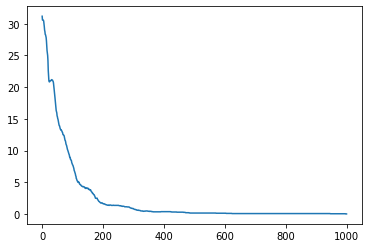

In [ ]:
# Plot the log loss over epochs
sns.lineplot(x=list(range(len(model.log_loss_hist))), y=model.log_loss_hist)

In [ ]:
# Make the prediction on test data and measure performance
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=0)
print(f"Accuracy Score: {np.round(accuracy_score(y_test, y_pred)*100,2)}")

Accuracy Score: 98.33


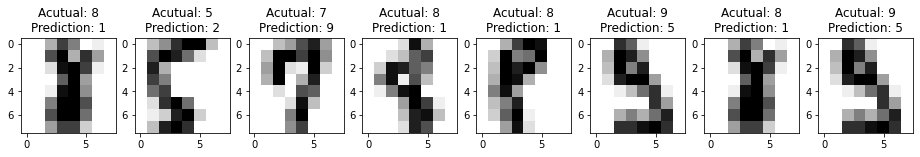

In [ ]:
# Plot the wrongly predicted images, to get an idea of mistakes model is making
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(16,2))
wrongs = y_pred != y_test
samp = X_test[wrongs]
y_samp_true = y_test[wrongs]
y_samp_pred = y_pred[wrongs]
n = len(samp)
for i in range(8):
    idx = np.random.randint(0, n)
    img = np.reshape(samp[idx]*16, (8,8))
    ax[i].imshow(img, cmap='gray_r')
    ax[i].set_title(f"Acutual: {y_samp_true[idx]}\nPrediction: {y_samp_pred[idx]}")

### v - Backpropagation with Neural Swap 